# This Example shows how to classify EuroSAT satellite images using the deep learning model DeepSAT-V2.

### EuroSAT satellite dataset contains images from 10 different classes:

<ul>
<li>Annual Crop</li>
<li>Forest</li>
<li>Herbaceous Vegetation</li>
<li>Highway</li>
<li>Industrial</li>
<li>Pasture</li>
<li>Permanent Crop</li>
<li>Residential</li>
<li>River</li>
<li>SeaLake</li>
</ul>

### Import Modules

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from geotorchai.models.raster import SatCNN
from geotorchai.preprocessing.torch_df import RasterClassificationDf
from geotorchai.preprocessing import SedonaRegistration, load_geotiff_image_as_binary_data
from geotorchai.preprocessing.raster import RasterProcessing as rp
from geotorchai.utility import TorchAdapter

# Import Apache Sedona
from sedona.spark import *

## Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf, expr, array, concat


## Import distributed modules
from torch.utils.data import DistributedSampler, DataLoader
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from pyspark.ml.torch.distributor import TorchDistributor
from petastorm import TransformSpec

import warnings
# Ignore FutureWarning warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Define spark session and Register with GeoTorchAI

In [2]:
config = SedonaContext.builder().master(MASTER_URL).config('spark.jars.packages',
           'org.apache.sedona:sedona-spark-shaded-3.4_2.12:1.4.1,'
           'org.datasyslab:geotools-wrapper:1.4.0-28.2').getOrCreate()

sedona = SedonaContext.create(config)
sc = sedona.sparkContext

23/08/14 09:17:25 WARN Utils: Your hostname, Kanchans-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.1.6 instead (on interface en0)
23/08/14 09:17:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/kanchan/.ivy2/cache
The jars for the packages stored in: /Users/kanchan/.ivy2/jars
org.apache.sedona#sedona-spark-shaded-3.4_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c494640b-7053-4922-9c25-5955aad784dc;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/kanchan/.pyenv/versions/3.11.0/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.sedona#sedona-spark-shaded-3.4_2.12;1.4.1 in central
	found org.datasyslab#geotools-wrapper;1.4.0-28.2 in central
:: resolution report :: resolve 101ms :: artifacts dl 3ms
	:: modules in use:
	org.apache.sedona#sedona-spark-shaded-3.4_2.12;1.4.1 from central in [default]
	org.datasyslab#geotools-wrapper;1.4.0-28.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-c494640b-7053-4922-9c25-5955aad784dc
	confs: [default]
	0 artifacts copied, 2 already retrieved (0kB/3ms)
23/08/14 09:17:25 WARN NativeCodeLoader: Unable to loa

### Register SparkSession with GeoTorchAI

In [3]:
SedonaRegistration.set_sedona_context(sedona)

## Load Raster Data to Sedona

In [4]:
raster_df = load_geotiff_image_as_binary_data("data/eurosat_total/*.tif")
raster_df.show(5)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [5]:
raster_df = rp.get_array_from_binary_raster(raster_df, 13, "content", col_new_array_data="array_data")
raster_df.show(5)

+--------------------+--------------------+------+--------------------+--------------------+
|                path|    modificationTime|length|             content|          array_data|
+--------------------+--------------------+------+--------------------+--------------------+
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1420.0, 1420.0, ...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1242.0, 1242.0, ...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1545.0, 1545.0, ...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1506.0, 1506.0, ...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1263.0, 1263.0, ...|
+--------------------+--------------------+------+--------------------+--------------------+
only showing top 5 rows



In [6]:
raster_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- array_data: array (nullable = true)
 |    |-- element: double (containsNull = true)



In [7]:
def get_name(file_path):
    return file_path.split("/")[-1].split("_")[0]

get_name_udf = udf(lambda x: get_name(x), StringType())

In [8]:
raster_df = raster_df.withColumn("category", get_name_udf(raster_df["path"]))
raster_df.show(5)

+--------------------+--------------------+------+--------------------+--------------------+----------+
|                path|    modificationTime|length|             content|          array_data|  category|
+--------------------+--------------------+------+--------------------+--------------------+----------+
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1420.0, 1420.0, ...|AnnualCrop|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1242.0, 1242.0, ...|AnnualCrop|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1545.0, 1545.0, ...|AnnualCrop|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1506.0, 1506.0, ...|AnnualCrop|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1263.0, 1263.0, ...|AnnualCrop|
+--------------------+--------------------+------+--------------------+--------------------+----------+
only showing top 5 rows



## Get the Number of Bands

In [9]:
raster_df = rp.get_raster_from_binary(raster_df, "content", new_column_name="raster_data")
raster_df = rp.get_num_bands(raster_df, "raster_data", new_column_name="n_bands").drop("raster_data")
raster_df.show(5)

+--------------------+--------------------+------+--------------------+--------------------+----------+-------+
|                path|    modificationTime|length|             content|          array_data|  category|n_bands|
+--------------------+--------------------+------+--------------------+--------------------+----------+-------+
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1420.0, 1420.0, ...|AnnualCrop|     13|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1242.0, 1242.0, ...|AnnualCrop|     13|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1545.0, 1545.0, ...|AnnualCrop|     13|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1506.0, 1506.0, ...|AnnualCrop|     13|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1263.0, 1263.0, ...|AnnualCrop|     13|
+--------------------+--------------------+------+--------------------+--------------------+----------+-

## Visualize the Bands of an Image

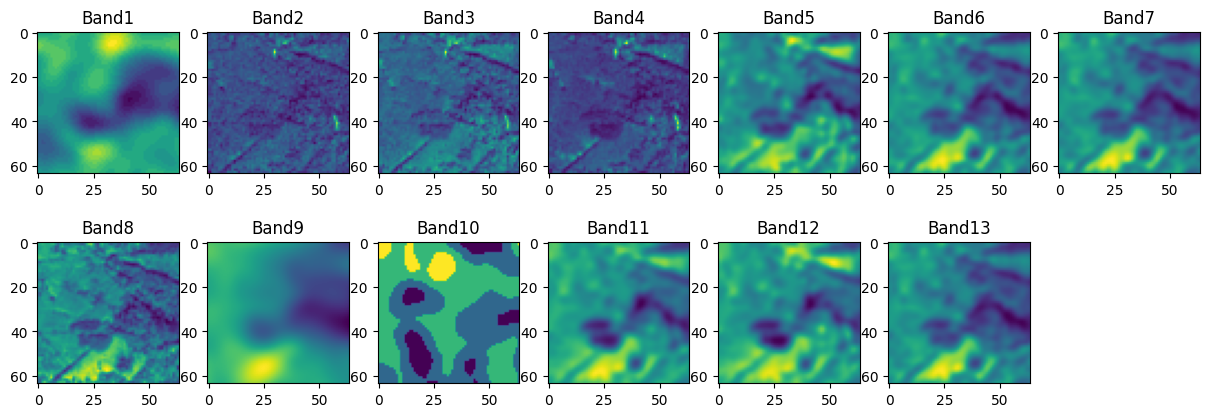

In [ ]:
img_index = 5
rp.visualize_all_bands(raster_df, "array_data", img_index, no_bands=13, height=64, width=64, axis_rows=2, axis_cols=7)

## Normalize the Bands

In [11]:
PATH_NORM_PARAMS = "models/satcnn_eurosat/norm_params.npy"
norm_params = np.load(PATH_NORM_PARAMS, allow_pickle=True).item()

In [12]:
raster_df = rp.get_normalized_array_data(raster_df, "array_data", norm_params['mean'].tolist(), norm_params['std'].tolist())
raster_df.show(5)

+--------------------+--------------------+------+--------------------+--------------------+----------+-------+---------------------+
|                path|    modificationTime|length|             content|          array_data|  category|n_bands|normalized_array_data|
+--------------------+--------------------+------+--------------------+--------------------+----------+-------+---------------------+
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1420.0, 1420.0, ...|AnnualCrop|     13| [0.27062551194701...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1242.0, 1242.0, ...|AnnualCrop|     13| [-0.4555724923202...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1545.0, 1545.0, ...|AnnualCrop|     13| [0.78059602056167...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00 08 0...|[1506.0, 1506.0, ...|AnnualCrop|     13| [0.62148522187390...|
|file:/Users/kanch...|2023-08-11 18:10:...|107244|[49 49 2A 00

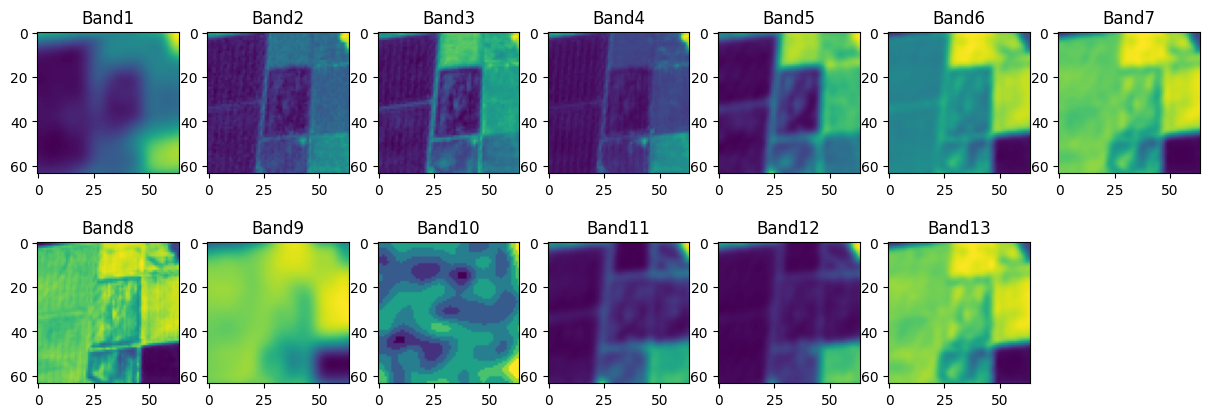

In [14]:
img_index = 1
rp.visualize_all_bands(raster_df, "normalized_array_data", img_index, no_bands=13, height=64, width=64, axis_rows=2, axis_cols=7)

## Convert into PyTorch Dataset Format

In [17]:
objRasterClassify = RasterClassificationDf(raster_df, "normalized_array_data", "category")
formatted_df = objRasterClassify.get_formatted_df()
transform_spec = objRasterClassify.get_transform_spec(13, 64, 64)
class_labels = objRasterClassify.get_class_labels()
class_labels

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

In [18]:
formatted_df.printSchema()

root
 |-- image_data: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- label: long (nullable = true)



In [19]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter
sedona.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, "file:///tmp/petastorm")

In [20]:
converter_data = make_spark_converter(formatted_df)

Converting floating-point columns to float32
The median size 585231 B (< 50 MB) of the parquet files is too small. Total size: 5586683 B. Increase the median file size by calling df.repartition(n) or df.coalesce(n), which might help improve the performance. Parquet files: file:///tmp/petastorm/20230814092137-appid-local-1692029846754-759474c3-03c7-44c5-8c8d-9b630071e941/part-00002-6e13a143-242f-4b8f-8187-579e60cef1d4-c000.parquet, ...


In [21]:
learning_rate = 0.0002
batch_size = 8
epoch_nums = 10

### Train Model
Accuracy will be very low since training is performed on a small dataset for only 2 epochs

In [22]:
def get_model():
    model = SatCNN(13, 64, 64, 10)
    return model

In [ ]:
def train_one_epoch(model, train_dataloader_iter, steps_per_epoch, optimizer, loss_fn, device):
    model.train()
    for step in range(steps_per_epoch):
        batch_data = next(train_dataloader_iter)
        inputs = batch_data['image_data']
        labels = batch_data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)
            
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
                
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
                
            # Backward and optimize
            loss.backward()
            optimizer.step()
    return loss.item()

In [ ]:
def train_model(model, device):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn.to(device)
    with converter_data.make_torch_dataloader(transform_spec=transform_spec, batch_size=batch_size) as train_dataloader:
        steps_per_epoch = len(converter_data) // batch_size
        train_dataloader_iter = iter(train_dataloader)
        for e in range(epoch_nums):
            epoch_loss = train_one_epoch(model, train_dataloader_iter, steps_per_epoch, optimizer, loss_fn)
            print('Epoch [{}/{}], Training Loss: {:.4f}'.format(e + 1, epoch_nums, epoch_loss))

In [ ]:
def train_distributed(use_gpu):
    backend = "nccl" if use_gpu else "gloo"
    dist.init_process_group(backend)
    device = int(os.environ["LOCAL_RANK"]) if use_gpu  else "cpu"
    model = get_model().to(device)
    model = DDP(model)
    
    output = train_model(model, device)
    #dist.cleanup()

## Start Distributed Training

In [ ]:
distributor = TorchDistributor(num_processes=4, local_mode=True, use_gpu=False)
distributor.run(train_distributed, False)

## Evaluate a Trained Model

In [23]:
MODEL_PATH = "models/satcnn_eurosat/satcnn_eurosat.pth"

### Load a pretrained model

In [24]:
def load_model(model_path, device):
    model = get_model()
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    return model

In [ ]:
def evaluate_model(model, dataloader_iter, num_setps, device):
    model.eval()
    
    total_sample = 0
    correct = 0
    for step in range(num_setps):
        batch_data = next(dataloader_iter)
        inputs = batch_data['image_data']
        labels = batch_data['label']
        inputs = inputs.to(device)
        labels = labels.to(device)
            
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            total_sample += len(labels)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
    return 100 * correct / total_sample

In [ ]:
def test_distributed(use_gpu):
    backend = "nccl" if use_gpu else "gloo"
    dist.init_process_group(backend)
    device = int(os.environ["LOCAL_RANK"]) if use_gpu  else "cpu"
    model = load_model(MODEL_PATH, device).to(device)
    model = DDP(model)
    
    with converter_data.make_torch_dataloader(transform_spec=transform_spec, batch_size=batch_size) as val_dataloader:
        num_steps = len(converter_train) // batch_size
        dataloader_iter = iter(val_dataloader)
        accuracy = evaluate_model(model, dataloader_iter, num_steps, device)
        print("Classification Accuracy: {0}%".format(accuracy))

## Start Distributed Testing

In [ ]:
distributor = TorchDistributor(num_processes=4, local_mode=True, use_gpu=False)
distributor.run(test_distributed, False)

## Classify a Single Image

In [25]:
device = TorchAdapter.get_training_device()
model = load_model(MODEL_PATH, device).to(device)
model.eval()

SatCNN(
  (sequences_part1): Sequential(
    (0): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): ZeroPad2d((32, 32, 32, 32))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): ZeroPad2d((32, 32, 32, 32))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): ZeroPad2d((32, 32, 32, 32))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequences_part2): Sequential(
    (0): Linear(in_features=524288, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

### Select the Raster Image Index for Classification

In [36]:
img_index = 1

In [37]:
with converter_data.make_torch_dataloader(transform_spec=transform_spec, batch_size=batch_size) as val_dataloader:
    data, index_in_loader = TorchAdapter.get_item_from_dataloader(val_dataloader, batch_size, img_index)
    inputs_actual = data['image_data'][index_in_loader]
    labels_actual = data['label'][index_in_loader].detach().cpu().numpy()
    inputs = inputs_actual.unsqueeze(0).to(device)
    
    outputs = model(inputs)
    probabilities = outputs.detach().cpu().numpy()[0]
    _, predicted = outputs.max(1)
    print("Predicted Class: ", class_labels[predicted.item()])
    print("Actual Class: ", class_labels[labels_actual.item()])

Predicted Class:  Pasture
Actual Class:  Pasture


## Display the Classified Image

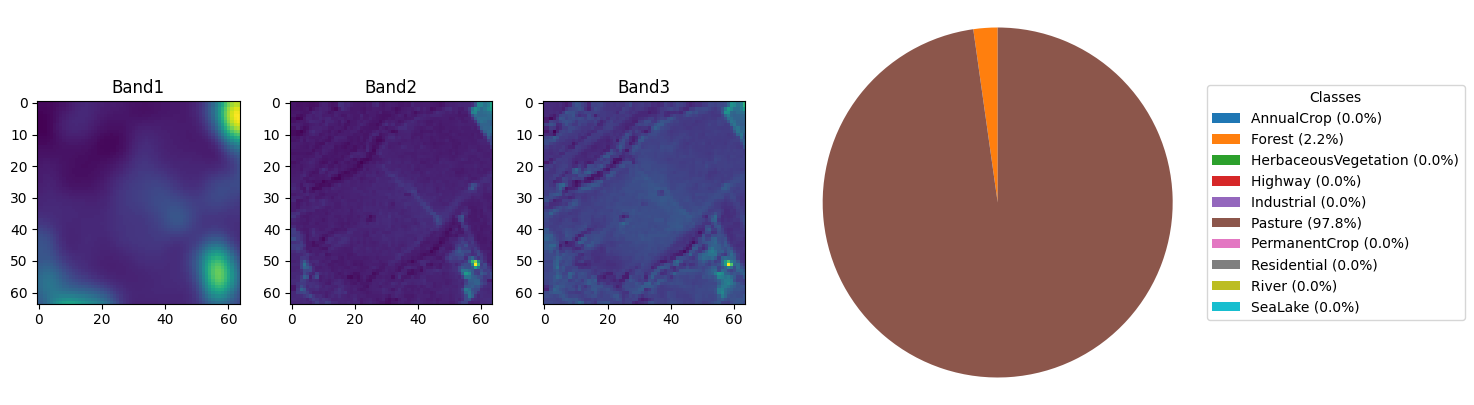

23/08/14 13:44:36 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 953699 ms exceeds timeout 120000 ms
23/08/14 13:44:36 WARN SparkContext: Killing executors is not supported by current scheduler.
23/08/14 13:44:39 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

23/08/14 13:44:48 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:44:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:45:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:45:18 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:45:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:45:48 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:45:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:46:08 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:46:18 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:46:28 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:46:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:46:48 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:46:58 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:47:18 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:47:28 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:47:48 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:47:58 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:48:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:48:18 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:48:28 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:48:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:48:48 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:48:58 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:49:08 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:49:18 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:49:38 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:49:48 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:49:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:50:08 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 13:50:18 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 13:50:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 14:00:44 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 14:00:54 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 14:01:04 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 14:01:14 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 14:01:24 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.Heartbeater$$anon$1.run(Heartbeater.scala:46)
	at java.base/j

23/08/14 14:01:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/08/14 14:01:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

In [38]:
TorchAdapter.visualize_bands_and_probabilities(inputs_actual, class_labels, probabilities)